# Test scripts on command line
Use this notebook as a test space

In [1]:
!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
!pip install pystac_client
from platform import python_version
python_version()
import sys
import os
sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils
from pyproj import CRS, Transformer
import geopandas as gpd
import maplib_folium
import pandas as pd

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/projects/Developer/icesat2_boreal/dps/requirements_main.txt'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 1.8 MB/s eta 0:00:00a 0:00:01


ModuleNotFoundError: No module named 'pandas'

In [2]:
%%time
!python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t ATL08_filt -y 2022 -m_list 04 --maap_version tile_atl08
#!python /projects/icesat2_boreal/lib/build_tindex_master.py -t ATL08_filt -y 2022 -m run_LC_height_thresholds -o /projects/my-private-bucket/

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		tile_atl08
Type:		ATL08_filt
Year:		2022
Month:		['04']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists
Nothing found. Check year and month. Exiting.
CPU times: user 30.5 ms, sys: 38.8 ms, total: 69.3 ms
Wall time: 4.3 s


### Read in some tiles layers

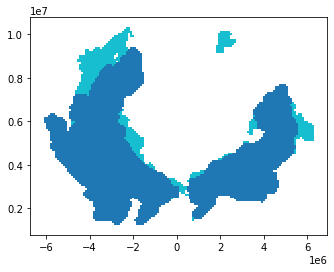

In [2]:
dem_tiles_index_path = '/projects/shared-buckets/nathanmthomas/dem30m_tiles.geojson'
dem_tiles_index = gpd.read_file(dem_tiles_index_path)
dem_tiles_index['tile_num'] = dem_tiles_index.index

boreal_tile_index_path = '/projects/my-public-bucket/boreal_tiles_v003.gpkg'
boreal_tile_index = gpd.read_file(boreal_tile_index_path)
boreal_tile_index.plot(column='tile_version')

#boreal_tile_index[boreal_tile_index.tile_version=='version 2']

In [3]:
if False:
    c = gpd.read_file('/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map.gpkg')
    c.path.to_list()[0]

In [4]:
if False:
    # One time, make a column with the s3 path
    c['s3_path'] = c['path'].str.replace('https://esa-worldcover.s3.eu-central-1.amazonaws.com', 's3://esa-worldcover') + '/' + c['file']

    c.s3_path.to_list()[0]
    c.to_file('/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg', driver='GPKG', overwrite=True)

#### Set up vars to pass to each script

In [5]:
#TILE_NUM = 12967
#INDEX_FN = '/projects/shared-buckets/lduncanson/dem30m_tiles_v2.geojson'#
#INDEX_LYR = 'dem30m_tiles_v2'

ID_COL_NAME = 'tile_num'
TILE_NUM = 1615 #1580 #, 3300, 3679, 3864 #27367 #1933 #3585 #1927 #131 #3417# 4253
INDEX_FN = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg'
INDEX_LYR = 'boreal_tiles_v003'

if False:
    HYBAS_FILE = 'hybas_lake_as_lev07_v1c'
    ID_COL_NAME = 'HYBAS_ID'
    TILE_NUM = 4070084980 #4070000010 #3417# 4253
    INDEX_FN = f'/projects/my-public-bucket/analyze_agb/hydrobasins/{HYBAS_FILE}.shp'
    ADD_STR = '-reprj'
    INDEX_REPRJ_FN = INDEX_FN.replace('.shp', ADD_STR+'.gpkg')
    
    # Reproject hydrobasin to equal area (boreal_tiles)
    gpd.read_file(INDEX_FN).to_crs(boreal_tile_index.crs).to_file(INDEX_REPRJ_FN, driver='GPKG')
    
    INDEX_LYR = HYBAS_FILE + ADD_STR
    z = gpd.read_file(INDEX_FN)
    
if False:
    z[z[ID_COL_NAME]==TILE_NUM].plot()

    z = gpd.read_file(INDEX_REPRJ_FN)
    z[z[ID_COL_NAME]==TILE_NUM].plot()

In [6]:
if False:
    c = gpd.read_file('/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg')
    c.head()

## Run build_stack.py with hydrobasins
* reprojected to equal area using boreal_tiles_index
* s0 output has same res and crs as output AGB vrt

In [7]:
RASTER_NAME = 'esa_worldcover_v100_2020'
COVAR_TILE_FN = '/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg'
IN_COVAR_S3_COL = 's3_path'
NODATA_VAL = 0

# This needs to be correctlyy in 4326 - 
RASTER_NAME = 'biomass_prelim'
COVAR_TILE_FN = '/projects/shared-buckets/lduncanson/DPS_tile_lists/AGB_tindex_master.json'
IN_COVAR_S3_COL = 's3'
NODATA_VAL = -9999

Reset projection and reproject...
/projects/my-public-bucket/analyze_agb/AGB_tindex_master.json


NameError: name 'z' is not defined

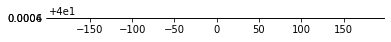

In [8]:
x = gpd.read_file(COVAR_TILE_FN)

if RASTER_NAME == 'biomass_prelim':

    print('Reset projection and reproject...')
    x = x.set_crs(boreal_tile_index.crs, allow_override=True, inplace=True).to_crs(4326)

    # Write a new JSON that should have the prj set correctly in 4326
    COVAR_TILE_FN = os.path.join('/projects/my-public-bucket/analyze_agb' , os.path.split(COVAR_TILE_FN)[1])
    print(COVAR_TILE_FN)
    x.to_file(COVAR_TILE_FN, driver='GeoJSON', overwrite=True)

# Verify 4326
ax = x.plot()
z[z[ID_COL_NAME]==TILE_NUM].to_crs(4326).plot(color='red', ax=ax)


In [247]:
# index shapes should be in equal area
# covar tiles should be in 4326
args = f"--in_tile_fn {INDEX_REPRJ_FN} \
--in_tile_id_col {ID_COL_NAME} \
--in_tile_num {TILE_NUM} \
--tile_buffer_m 0 \
--in_tile_layer {INDEX_LYR} \
-o /projects/test_data/ \
--topo_off \
--covar_src_name {RASTER_NAME} \
--covar_tile_fn {COVAR_TILE_FN} \
--in_covar_s3_col {IN_COVAR_S3_COL} \
--input_nodata_value {NODATA_VAL} \
--clip" #<-- testing a clip to polygon
print(args)
!python build_stack.py $args

--in_tile_fn /projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_as_lev07_v1c-reprj.gpkg --in_tile_id_col HYBAS_ID --in_tile_num 4070084980 --tile_buffer_m 0 --in_tile_layer hybas_lake_as_lev07_v1c-reprj -o /projects/test_data/ --topo_off --covar_src_name biomass_prelim --covar_tile_fn /projects/my-public-bucket/analyze_agb/AGB_tindex_master.json --in_covar_s3_col s3 --input_nodata_value -9999 --clip
/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
The covariate's filename(s) intersecting the 0 m bbox for tile id 4070084980:
 s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_ubuntu/master/2021/10/16/05/28/01/047798/boreal_agb_20211016_3975_cog.tif
s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_ubuntu

In [248]:
cog_fn = '/projects/tmp/esa_worldcover_v100_2020_131_cog.tif'
cog_fn = f'/projects/tmp/{RASTER_NAME}_{TILE_NUM}_cog.tif'
covar_stack_names = ['esa worldcover']

/projects/tmp/biomass_prelim_4070084980_cog.tif
4
(3813, 1930)
(3813, 1930)
-1.0075219858189395e+43


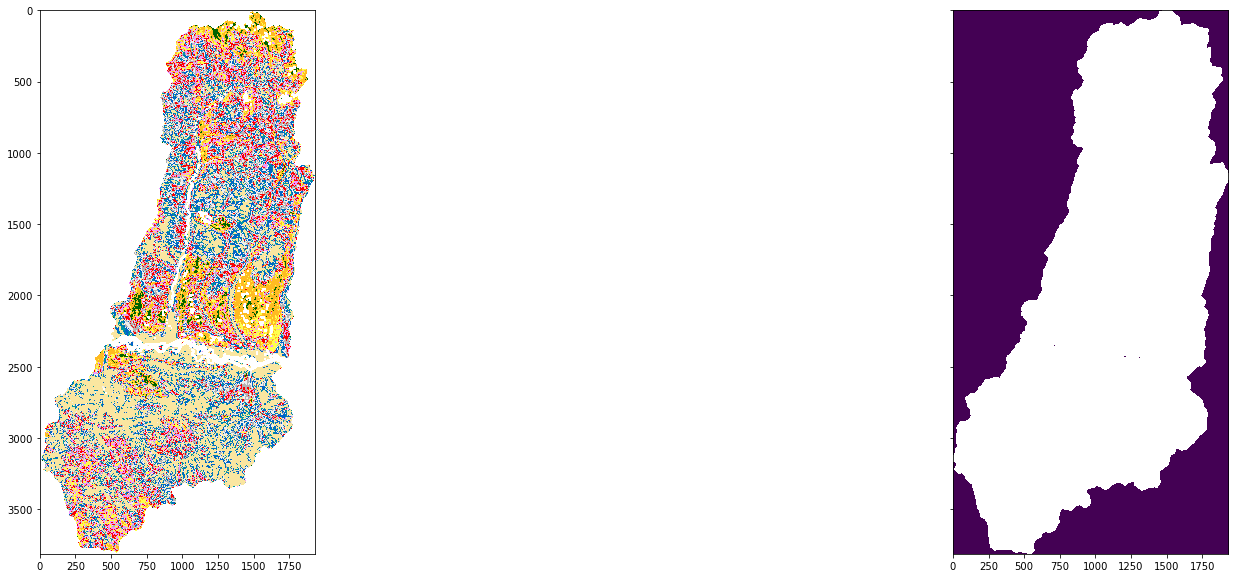

In [249]:
## %%time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import rasterio
from rasterio.plot import show_hist, show
import numpy.ma as ma

# Read back in the topo_stack_cog_fn and plot
print(cog_fn)
with rasterio.open(cog_fn) as dataset:

    print(dataset.count)
    
    covar_stack = dataset.read(1)
    print(covar_stack.shape)

    lc_mask = covar_stack.copy()
    print(lc_mask.shape)
    
    # For LC value of interest, set to 1, else mask out
    LC_VAL = 90
    #lc_mask = np.ma.masked_array(covar_stack, mask=covar_stack[covar_stack != 10], fill_value=1)
    #lc_mask = ma.masked_where(covar_stack == LC_VAL, 1)
    lc_mask[np.where(covar_stack > 0)] = 0
    lc_mask[np.where(covar_stack == LC_VAL)] = 1
    
    lc_mask = ma.masked_values(lc_mask, 0)
    print(lc_mask.sum())
    
    names_worldcover = ['nodata','Trees', 'Shrubland', 'Grassland','Cropland','Built-up','Barren / sparse vegetation','Snow and ice','Open water','Herbaceous wetland','Mangroves','Moss and lichen']
    cols_worldcover = ["white","#006400","#ffbb22","#ffff4c","#f096ff","#fa0000","#b4b4b4","#f0f0f0","#0064c8","#0096a0","#00cf75","#fae6a0"]
    #cols_worldcover = ["white","green","orange","yellow","purple","red","brown","gray","blue","pink","cyan","black"]
    cols_mask = ["white", "red"]
    # Plot data using nicer colors

    values_worldcover = [0,10,20,30,40,50,60,70,80,90,95,100]
    values_mask = [0,1]
    
    cmap_worldcover = ListedColormap(cols_worldcover)
    norm_worldcover = BoundaryNorm(values_worldcover, len(cols_worldcover))
    
    cmap_masked = ListedColormap(cols_mask)
    norm_masked= BoundaryNorm(values_mask, len(cols_mask))

    # To plot with a legend:
    # https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/classify-plot-raster-data-in-python/
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30,10), sharex=True, sharey=True)
    ax1.imshow(covar_stack, cmap=cmap_worldcover, norm=norm_worldcover)
    ax2.imshow(lc_mask, clim=(0,1))
    #show(lc_mask, cmap=cmap_masked, norm=norm_masked)
    #show_hist(lc_mask, bins=len(values_masked)+1, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram of ESA Worldcover Class Values")

In [ ]:
# This should work once you figure out the move axis of the stack: need 3 bands
n: int = len(covar_stack)
covar_stack_cmaps = ["Spectral"]
print(covar_stack.shape)

fig, axes = plt.subplots(1,n, figsize=(n*3,5))

for i in range(n):
    
    print(covar_stack[i].min(), covar_stack[i].max())
    array_to_show = covar_stack[i]
    clims = (np.nanpercentile(covar_stack[i], 10), np.nanpercentile(covar_stack[i], 90))
    
    if 'elevation' in covar_stack_names[i]:
        #Replace elevation with its hillshade for display purposes
        array_to_show = hillshade(covar_stack[i],315,45)
        clims = None
    
    show(array_to_show, ax=axes[i], cmap=covar_stack_cmaps[i], clim=clims, title=covar_stack_names[i])
    
    fig, (axmap, axhist) = plt.subplots(1,2, figsize=(10,5))
    show(array_to_show, ax=axmap, cmap=covar_cmaps[i], clim=clims, title=covar_stack_names[i])
    show_hist(covar_stack[i], ax=axhist, title=covar_stack_names[i], bins=50, lw=0.0, stacked=True, alpha=1)


if False:
    fig, axes = plt.subplots(1,n, figsize=(n*3,30))

    for i in range(n):
        show_hist(covar_stack[i], ax=axes[i], title=covar_stack_names[i], bins=50, lw=0.0, stacked=True, alpha=1)

# Tile size tests

Here are the bad tiles Nathan identified in `Find_small_tiles.ipynb`

In [104]:
df = pd.read_csv('/projects/my-public-bucket/DPS_tile_lists/HLS_irregular_tiles.csv')
#boreal_tile_index = gpd.read_file('/projects/my-public-bucket/boreal_tiles_v003.gpkg')#.to_crs(4326)

#geom_list = []
tile_num_list = []

for i in df["IrregularTiles"]:
    tile_num = int(i.split('_')[9])
    #geom_list.append((boreal_tile_index['geometry'][boreal_tile_index['tile_num']==tile_num]).geometry.values[0])
    tile_num_list.append(tile_num)
    
print(tile_num_list)

[1941, 2149, 2457, 1448, 1867, 1797, 2010, 1105, 2155, 2779, 1159, 991, 2082, 1731, 2148, 3770, 2301, 36692, 1937, 37142, 37143, 4108, 1334, 36917, 3307, 3951, 3393, 1392, 3486, 2009, 2075, 1798, 2378, 3771, 1273, 1393, 34674, 1050, 1214, 1615, 1938, 2942, 3865, 2223, 2859]


In [88]:

# Already tested these tiles:
# 1615
TILE_NUM = tile_num_list[0] 


# Testing shape forcing on bad and good tiles
Does forcing shape do anything to bad tiles , good tiles
bad tiles: eg 1615  
good tiles: eg 1614  

Results (explore_tiles.qgis)  
`--shape` is the best way to get aligned results for bad and good tiles for HLS, LC, and Topo

For now, always run Topos with `3.1.5_dps.py` instead of trying to do a topo run with `build_stack.py`

however, still a few issues - and they seem to be with `build_stack.py`:  
1. not clear how to get LC (`build_stack.py`) to return the same grid as HLS (`3.1.2_dps.py`) and Topo stack (`3.1.5_dps.py`)
2. results from (`build_stack.py`) shows a nodata (0 value) on half of right side and half of bottom side of good & bad tiles  
3. topo (from `build_stack.py`) show similar nodata pattern, but sometimes its 2 pixels on half of right side. 

In [8]:
OUTDIR = '/projects/test_data'
OUTDIR_SHAPE_ON = OUTDIR + '/shape_on'
OUTDIR_SHAPE_OFF = OUTDIR + '/shape_off'
# Manually set align=True for write_cog() in build_stack
OUTDIR_SHAPE_ON_align = OUTDIR + '/shape_on_align'
OUTDIR_SHAPE_OFF_align = OUTDIR + '/shape_off_align'
!mkdir -p $OUTDIR_SHAPE_ON
!mkdir -p $OUTDIR_SHAPE_OFF
!mkdir -p $OUTDIR_SHAPE_ON_align
!mkdir -p $OUTDIR_SHAPE_OFF_align

#### original topo tiles from 3.1.5_dps.py all seem good (3000x3000)

In [9]:
import rasterio as rio
t = pd.read_csv('/projects/my-public-bucket/DPS_tile_lists/Topo_tindex_master.csv')
f = t[t.tile_num == TILE_NUM].s3_path.to_list()[0]
ds = rio.open(f)
print(f"Tile #: {TILE_NUM}\n{f}\n{ds.profile['height']} x {ds.profile['width']}")
print(f"CRS of Topo:\n{ds.crs}")
print(f"CRS of tiles index:\n{boreal_tile_index.crs}")

Tile #: 1615
s3://maap-ops-workspace/nathanmthomas/dps_output/do_topo_stack_3-1-5_ubuntu/ops/2021/09/16/03/56/41/782830/Copernicus_1615_covars_cog_topo_stack.tif
3000 x 3000
CRS of Topo:
PROJCS["unknown",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
CRS of tiles index:
PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["

In [91]:
import s3fs
s3 = s3fs.S3FileSystem(anon=True)
s3.download(f, '/projects/test_data/dload/'+os.path.basename(f))

#### build_stack.py with ESA LC

RESULT:  

When build_stack.py is run with `--shape 3000` ..  
..the fit to the tile geom is good, but there is a NoData line of pixels
  
bad tiles and good tiles?  
fits perfectly in tile geom? yes    
no half pixel shift? no

Does HLS `--shape 3000` show same result?  

In [11]:
# ESA Worldcover 2020
BUILD_STACK_DICT = {
            #'INDEX_FN': '/projects/my-public-bucket/boreal_tiles_v003.gpkg',
            'INDEX_FN': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v003.gpkg',
            'ID_COL_NAME': 'tile_num',
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR': 'boreal_tiles_v003',
            # Worldcover data is accessed via its footprint, with a 's3_path' col identifying the s3 locations of each tile
            'RASTER_NAME': 'esa_worldcover_v100_2020',
            #'COVAR_TILE_FN': '/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg',
            'COVAR_TILE_FN': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'OUTDIR': '',
            'NODATA_VAL': 0,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        }

In [15]:
# INDEX clip shapes should be in equal area
# COVAR_TILE_FN tiles (of raster COGs) should be in 4326

args = f"\
    --in_tile_fn {BUILD_STACK_DICT['INDEX_FN']} \
    --in_tile_id_col {BUILD_STACK_DICT['ID_COL_NAME']} \
    --tile_buffer_m 0 \
    --in_tile_layer {BUILD_STACK_DICT['INDEX_LYR']} \
    --topo_off \
    --covar_src_name {BUILD_STACK_DICT['RASTER_NAME']} \
    --covar_tile_fn {BUILD_STACK_DICT['COVAR_TILE_FN']} \
    --in_covar_s3_col {BUILD_STACK_DICT['IN_COVAR_S3_COL']} \
    --input_nodata_value {BUILD_STACK_DICT['NODATA_VAL']} \
    --clip"

args_LIST = []

if False:
    # Bad tile; Forcing shape (SHAPE ON)
    args_LIST.append(args + f" --in_tile_num {TILE_NUM} --shape 3000 -o {OUTDIR_SHAPE_ON}")
    # Good tile; Forcing shape (SHAPE ON)
    args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} --shape 3000 -o {OUTDIR_SHAPE_ON}")
    # Bad tile; Not forcing shape (SHAPE OFF)
    args_LIST.append(args + f" --in_tile_num {TILE_NUM} -o {OUTDIR_SHAPE_OFF}")
    # Good tile; Not forcing shape (SHAPE OFF)
    args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} -o {OUTDIR_SHAPE_OFF}")

# align=True test
# To run these, manually set align=True for write_cog() in build_stack
# Bad tile; Forcing shape (SHAPE ON)
if True:
    # Bad tile; Forcing shape (SHAPE ON)
    args_LIST.append(args + f" --in_tile_num {TILE_NUM} --shape 3000 -o {OUTDIR_SHAPE_ON_align}")
    # Good tile; Forcing shape (SHAPE ON)
    args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} --shape 3000 -o {OUTDIR_SHAPE_ON_align}")
    # Bad tile; Not forcing shape (SHAPE OFF)
    args_LIST.append(args + f" --in_tile_num {TILE_NUM} -o {OUTDIR_SHAPE_OFF_align}")
    # Good tile; Not forcing shape (SHAPE OFF)
    args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} -o {OUTDIR_SHAPE_OFF_align}")

for args in args_LIST:
    !python /projects/Developer/icesat2_boreal/lib/build_stack.py $args

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

---Running build_stack()---

The covariate's filename(s) intersecting the 0 m buffered bbox for tile id 1615:
 s3://esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N45W084_Map.tif
in_bbox: [5048522.564673773, 5193303.643996402, 5138522.529666357, 5283303.645755118]
Getting output height and width from input shape arg...
3000 x 3000
Writing stack as cloud-optimized geotiff: /projects/test_data/shape_on_align/esa_worldcover_v100_2020_1615_cog.tif
Clipping to feature polygon...
Orig stack shape:		 (1, 3000, 3000)
Output resolution:		 (30, 30)
Writing img to memory...
/projects/Developer/icesat2_boreal/lib/build_stack.py:104: RasterioDeprecationWarning: Source dataset should be ope

#### build_stack.py for a topo stack

##### TODO: check build_stack for topo stack creation (topo_off = False)
is build_stack actually clipping to clip_geom (line 81) so that a buffered DEM is clipped down to 3000x3000 after making the topo stack covars? Seems like its not. Check this

In [100]:
args = f"\
    --in_tile_fn {INDEX_FN} \
    --in_tile_id_col tile_num \
    --in_tile_num {TILE_NUM} \
    --tile_buffer_m 120 \
    --in_tile_layer {INDEX_LYR} \
    --covar_src_name Copernicus_buildstack \
    --covar_tile_fn /projects/shared-buckets/nathanmthomas/dem30m_tiles.geojson \
    --in_covar_s3_col s3 \
    --clip"
args_LIST = []
# Bad tile; Forcing shape (SHAPE ON)
args_LIST.append(args + f" --in_tile_num {TILE_NUM} --shape 3000 -o {OUTDIR_SHAPE_ON}")
# Good tile; Forcing shape (SHAPE ON)
args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} --shape 3000 -o {OUTDIR_SHAPE_ON}")
# Bad tile; Not forcing shape (SHAPE OFF)
args_LIST.append(args + f" --in_tile_num {TILE_NUM} -o {OUTDIR_SHAPE_OFF}")
# Good tile; Not forcing shape (SHAPE OFF)
args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} -o {OUTDIR_SHAPE_OFF}")

for args in args_LIST:
    !python /projects/Developer/icesat2_boreal/lib/build_stack.py $args

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

---Running build_stack()---

The covariate's filename(s) intersecting the 120 m buffered bbox for tile id 1941:
 s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N42_00_W088_00_DEM/Copernicus_DSM_COG_10_N42_00_W088_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N42_00_W089_00_DEM/Copernicus_DSM_COG_10_N42_00_W089_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N43_00_W088_00_DEM/Copernicus_DSM_COG_10_N43_00_W088_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N43_00_W089_00_DEM/Copernicus_DSM_COG_10_N43_00_W089_00_DEM.tif
in_bbox: [5408402.053990538, 4743183.9877320975, 5498642.025561074, 4833424.068427608]
Getting output height and width from buffered (buffer=12

#### Test a run of the topo stacks: 3.1.5_dps.py

In [101]:
args = f"--in_tile_fn {INDEX_FN} \
--in_tile_num {TILE_NUM} \
--tile_buffer_m 120 \
--in_tile_layer {INDEX_LYR} \
--topo_tile_fn /projects/shared-buckets/nathanmthomas/dem30m_tiles.geojson"

args_LIST = []
# Bad tile; Forcing shape (SHAPE ON)
args_LIST.append(args + f" --in_tile_num {TILE_NUM} --shape 3000 -o {OUTDIR_SHAPE_ON}")
# Good tile; Forcing shape (SHAPE ON)
args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} --shape 3000 -o {OUTDIR_SHAPE_ON}")
# Bad tile; Not forcing shape (SHAPE OFF)
args_LIST.append(args + f" --in_tile_num {TILE_NUM} -o {OUTDIR_SHAPE_OFF}")
# Good tile; Not forcing shape (SHAPE OFF)
args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} -o {OUTDIR_SHAPE_OFF}")

for args in args_LIST:
    !python 3.1.5_dps.py $args

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
The DEM filename(s) intersecting the 120 m buffered bbox for tile id 1941:
 s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N42_00_W088_00_DEM/Copernicus_DSM_COG_10_N42_00_W088_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N42_00_W089_00_DEM/Copernicus_DSM_COG_10_N42_00_W089_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N43_00_W088_00_DEM/Copernicus_DSM_COG_10_N43_00_W088_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N43_00_W089_00_DEM/Copernicus_DSM_COG_10_N43_00_W089_00_DEM.tif
in_bbox: [5408402.053990538, 4743183.9877320975, 5498642.025561074, 4833424.068427608]
Getting output height and width from input shape arg...
3000 x 3000
Input nodata isnt provided

In [58]:
ds = rio.open('/projects/test_data/Copernicus_1615_cog_topo_stack.tif')
print(f"{ds.profile['height']} x {ds.profile['width']}")

3001 x 3000


### Examine `HLS` composite types: combined S30 and L30

In [146]:
# These tiles had artifacts in the 2019-2021 HLS comp with L30

# 2021 is first year S30 is available it seems

# Can we improve on c2020 comps (2019-2021) with a 2021 comp using S30 & L30 for Jule-August

TILES_with_artefacts_LIST = [237,984,702,1858,3387]

In [147]:
MS_DATA_TYPE = 'HLS'#'LS8' # 'HLS'

if MS_DATA_TYPE == 'LS8':
    SAT_API = 'https://landsatlook.usgs.gov/sat-api'
else:
    SAT_API = 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD'
    
MAX_CLOUDS = 50
SEASON_START = '07-01'
SEASON_STOP = '08-15'
YEAR_START = '2021'
YEAR_STOP = '2021'
RUN_NAME = f'mc{MAX_CLOUDS}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}'
RUN_NAME

'mc50_07-01_08-15_2021_2021'

##### 3.1.2_dps.py

In [148]:
for TILE_NUM in TILES_with_artefacts_LIST:

    # Loop over the HLS product here
    for HLS_PRODUCT in ['S30','L30','H30']:

        OUTDIR = f'/projects/test_data/HLS_testing/{HLS_PRODUCT}'
        !mkdir -p $OUTDIR

        args = f"-i {INDEX_FN} \
        --composite_type {MS_DATA_TYPE} \
        -lyr {INDEX_LYR} \
        -a {SAT_API} \
        --tile_buffer_m 0 \
        --in_tile_num {TILE_NUM} \
        -o {OUTDIR} \
        -sy {YEAR_START} -ey {YEAR_STOP} -smd {SEASON_START} -emd {SEASON_STOP} -mc {MAX_CLOUDS} -t {MS_DATA_TYPE} \
        --shape 3000 \
        --hls_product {HLS_PRODUCT}"

        #!python 3.1.2_dps.py $args
        cmd = f'python 3.1.2_dps.py {args}'
        !echo $cmd
        !echo
        !eval $cmd

python 3.1.2_dps.py -i /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg --composite_type HLS -lyr boreal_tiles_v003 -a https://cmr.earthdata.nasa.gov/stac/LPCLOUD --tile_buffer_m 0 --in_tile_num 237 -o /projects/test_data/HLS_testing/S30 -sy 2021 -ey 2021 -smd 07-01 -emd 08-15 -mc 50 -t HLS --shape 3000 --hls_product S30

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Tiles path:		 /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg
Tile number:		 237
Output res (m):		 30
in_bbox:		 [-2871478.0000000047, 7893304.000000009, -2781478.0000000047, 7983304.000000009]
bbox 4326:		 [31.484204400240426, 61.34666526224287, 33.90972227535535, 62.45647776409287]
Getting output dims from input shape arg...
Output dims:		30

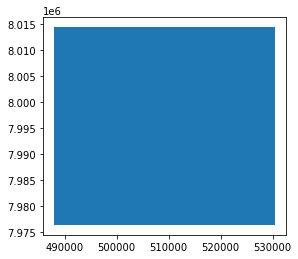

In [30]:
INDEX_FN = '/projects/test_data/SajamaAOI.gpkg'
#PROJECTED_FN = '/projects/test_data/SajamaAOI_albers.gpkg'
#gpd.read_file(INDEX_FN).to_crs(gpd.read_file('/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg').crs).to_file(PROJECTED_FN, driver='GPKG')

PROJECTED_FN = '/projects/test_data/SajamaAOI_utm.gpkg'
gpd.read_file(INDEX_FN).to_crs(32719).to_file(PROJECTED_FN, driver='GPKG')
c = gpd.read_file(PROJECTED_FN)
c.plot()

In [24]:
import fiona
from CovariateUtils import *

In [31]:
INDEX_FN = PROJECTED_FN

INDEX_LYR = fiona.listlayers(INDEX_FN)[0]
OUTDIR_SAJAMA = '/projects/test_data/test_sajama'

args = f"-i {INDEX_FN} \
-lyr {INDEX_LYR} \
-a {SAT_API} \
--tile_buffer_m 0 \
--in_tile_num 1 \
-o {OUTDIR_SAJAMA} \
-sy {YEAR_START} -ey {YEAR_STOP} -smd {SEASON_START} -emd {SEASON_STOP} -mc {MAX_CLOUDS} -t {MS_DATA_TYPE}"

!python 3.1.2_dps.py $args

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Tiles path:		 /projects/test_data/SajamaAOI_utm.gpkg
Tile number:		 1
Output res (m):		 30
in_bbox:		 [487913.4904594717, 7976366.239692333, 530423.454751463, 8014410.17662341]
bbox 4326:		 [-69.11436803499998, -18.30228742199995, -68.71212059899995, -17.958248279999964]
Getting output height and width from buffered (buffer=0.0) original tile geometry...
1268 x 1416
get HLS data
run function
opening client
start_month_day:		 07-15
start date, end date:		 2015-07-15T00:00:00Z 2015-09-01T23:59:59Z

Conducting HLS search now...
Search query parameters:

initial results:		 12
filtered results:		 6

Search complete.

6
# of files per band:		 6
Example path to a band:		 s3://lp-prod-protected/

In [103]:
args_LIST = []

args = f"-i {INDEX_FN} \
-lyr {INDEX_LYR} \
-a {SAT_API} \
--tile_buffer_m 0 \
-sy {YEAR_START} -ey {YEAR_STOP} -smd {SEASON_START} -emd {SEASON_STOP} -mc {MAX_CLOUDS} -t {MS_DATA_TYPE}"

# Bad tile; Forcing shape (SHAPE ON)
args_LIST.append(args + f" --in_tile_num {TILE_NUM} --shape 3000 -o {OUTDIR_SHAPE_ON}")
# Good tile; Forcing shape (SHAPE ON)
args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} --shape 3000 -o {OUTDIR_SHAPE_ON}")
# Bad tile; Not forcing shape (SHAPE OFF)
args_LIST.append(args + f" --in_tile_num {TILE_NUM} -o {OUTDIR_SHAPE_OFF}")
# Good tile; Not forcing shape (SHAPE OFF)
args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} -o {OUTDIR_SHAPE_OFF}")

for args in args_LIST:
    #print(args)
    !python 3.1.2_dps.py $args

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Tiles path:		 /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg
Tile number:		 1941
Output res (m):		 30
in_bbox:		 [5408522.053990538, 4743303.9877320975, 5498522.025561074, 4833304.068427608]
bbox 4326:		 [-88.77776561375481, 42.685095496309216, -87.49516749159045, 43.66060430674119]
Getting output height and width from input shape arg...
3000 x 3000
get HLS data
run function
opening client
start_month_day:		 07-15
start date, end date:		 2015-07-15T00:00:00Z 2015-09-01T23:59:59Z

Conducting HLS search now...
Search query parameters:

initial results:		 24
filtered results:		 16

Search complete.

16
# of files per band:		 16
Example path to a band:		 s3://lp-prod-protected

# tile_atl08

#### Test a run of tile_atl08.py

In [115]:
!python /projects/register-algorithm /projects/Developer/icesat2_boreal/dps/alg_2-4/algorithm_config.yaml

{
  "algorithm_name": "run_tile_atl08",
  "code_version": "tile_atl08",
  "environment_name": "ubuntu",
  "repo_url": "https://repo.ops.maap-project.org/icesat2_boreal/icesat2_boreal.git",
  "docker_container_url": "mas.maap-project.org:5000/root/ade-base-images/r:latest",
  "queue": "maap-dps-worker-8gb",
  "algorithm_description": null,
  "build_command": "icesat2_boreal/dps/build_command_main.sh",
  "script_command": "icesat2_boreal/dps/alg_2-4/run_tile_atl08.sh",
  "disk_space": "10GB",
  "algorithm_params": [
    {
      "field": "in_tile_num",
      "download": false
    },
    {
      "field": "in_tile_fn",
      "download": true
    },
    {
      "field": "in_tile_layer",
      "download": false
    },
    {
      "field": "csv_list_fn",
      "download": false
    },
    {
      "field": "topo_stack_list_fn",
      "download": false
    },
    {
      "field": "landsat_stack_list_fn",
      "download": false
    },
    {
      "field": "landsat_cols_list",
      "download": f

## Run tile_atl08 over a list of tiles  
for what will be tiles with dummy output ATL08 data frames (1 obs)

In [122]:
OUTDIR = '/projects/my-public-bucket/tile_atl08'
!mkdir -p $OUTDIR

INCOMPLETE_IRREG_IILES = [2375, 3301, 3302, 3117, 4034]

TILE_NUM_LIST = [3653, 4151, 3827, 40664, 2745,
                 1321, 1326, 1318, 611, 577, 976, 1316, 36019, 36238, 36237,
                 36685, 39464, 4418, 4308, 4024, 4107, 4104, 4029, 2505, 
                 3417, 41809, 42558, 24113, 24394, 24674, 26341, 26340, 
                 25184, 40239, 39832, 36401, 35285, 35059,
                 35060, 34834, 34606, 3402, 3215, 3035, 2782, 1278, 1108, 26554, 
                 10, 21, 155, 250, 357, 448, 484, 608, 609, 650, 738, 34607, 35955, 37080, 39630, 4150, 4141, 4366, 3978]
len(TILE_NUM_LIST)
NEED_LIST = []
HAVE_LIST = []
for TILE_NUM in TILE_NUM_LIST:
    f1 = os.path.exists(os.path.join(OUTDIR, f'atl08_005_30m_filt_topo_landsat_20230211_{TILE_NUM:{0}{4}}.csv'))
    f2 = os.path.exists(os.path.join(OUTDIR, f'atl08_005_30m_filt_topo_landsat_20230212_{TILE_NUM:{0}{4}}.csv'))
    f3 = os.path.exists(os.path.join(OUTDIR, f'atl08_005_30m_filt_topo_landsat_20230213_{TILE_NUM:{0}{4}}.csv'))
                        
    if not f1 and not f2:
        NEED_LIST.append(TILE_NUM)
    else:
        HAVE_LIST.append(TILE_NUM)
print(NEED_LIST)
print(HAVE_LIST)

[]
[3653, 4151, 3827, 40664, 2745, 1321, 1326, 1318, 611, 577, 976, 1316, 36019, 36238, 36237, 36685, 39464, 4418, 4308, 4024, 4107, 4104, 4029, 2505, 3417, 41809, 42558, 24113, 24394, 24674, 26341, 26340, 25184, 40239, 39832, 36401, 35285, 35059, 35060, 34834, 34606, 3402, 3215, 3035, 2782, 1278, 1108, 26554, 10, 21, 155, 250, 357, 448, 484, 608, 609, 650, 738, 34607, 35955, 37080, 39630, 4150, 4141, 4366, 3978]


In [121]:
%%time

TILE_NUM_LIST = NEED_LIST

for TILE_NUM in TILE_NUM_LIST:
    args = f"\
    -LC_filter True \
    --extract_covars \
    --do_30m \
    --do_dps \
    -years_list 2019 2020 2021 \
    -o {OUTDIR} \
    -in_tile_num {TILE_NUM} \
    -in_tile_fn {INDEX_FN} \
    -in_tile_layer {INDEX_LYR} \
    -in_tile_id_col tile_num \
    -csv_list_fn /projects/shared-buckets/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_tindex_master.csv \
    -topo_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv \
    -landsat_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master.csv \
    -landsat_cols_list Blue Green Red NIR SWIR SWIR2 NDVI SAVI MSAVI NDMI EVI NBR NBR2 TCB TCG TCW ValidMask Xgeo Ygeo JulianDate yearDate \
    -user_stacks nathanmthomas \
    -user_atl08 lduncanson \
    -thresh_sol_el 5 \
    -v_ATL08 5 -minmonth 4 -maxmonth 10"
    print(args)
    !python tile_atl08.py $args

    -LC_filter True     --extract_covars     --do_30m     --do_dps     -years_list 2019 2020 2021     -o /projects/my-public-bucket/tile_atl08     -in_tile_num 39630     -in_tile_fn /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg     -in_tile_layer boreal_tiles_v003     -in_tile_id_col tile_num     -csv_list_fn /projects/shared-buckets/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_tindex_master.csv     -topo_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv     -landsat_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master.csv     -landsat_cols_list Blue Green Red NIR SWIR SWIR2 NDVI SAVI MSAVI NDMI EVI NBR NBR2 TCB TCG TCW ValidMask Xgeo Ygeo JulianDate yearDate     -user_stacks nathanmthomas     -user_atl08 lduncanson     -thresh_sol_el 5     -v_ATL08 5 -minmonth 4 -maxmonth 10
/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning

In [54]:


rds_fn = tindex.tail().local_path.to_list()[0].replace('.tif', '_stats.Rds').replace('/projects/my-private-bucket','s3://maap-ops-workspace/lduncanson')
print(rds_fn)
rds_fn
local_rds_fn = '/projects/test_data/' + os.path.basename(rds_fn)
local_rds_fn

s3 = s3fs.S3FileSystem(anon=True)
s3.download(rds_fn, local_rds_fn)

result = pyreadr.read_r(local_rds_fn) # also works for RData

# done! 
# result is a dictionary where keys are the name of objects and the values python
# objects. In the case of Rds there is only one object with None as key
#df = result[None] # extract the pandas data frame 

s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_v3/2022/11/11/22/38/21/238233/boreal_agb_202211111668206230_25745_stats.Rds


In [55]:
result

OrderedDict()

In [1]:
import pandas as pd

In [3]:
IRREGULAR_TILES_FN = '/projects/my-public-bucket/DPS_tile_lists/HLS_irregular_tiles.csv'
original_IRREGULAR_TILES_LIST = []
df = pd.read_csv(IRREGULAR_TILES_FN)

for i in df["IrregularTiles"]:
    tile_num = int(i.split('_')[9])
    original_IRREGULAR_TILES_LIST.append(tile_num)



In [8]:
TILES_IRREGULAR_LIST = [3400,
 3395,
 2698,
 3301,
 992,
 993,
 1216,
 1800,
 1934,
 1933,
 3030,
 1617,
 3302,
 2380,
 2619,
 3952,
 3493,
 1866,
 4035,
 1672,
 34900,
 1274,
 34899,
 36020,
 36468,
 3399,
 4227,
 34210,
 2618,
 1450,
 2944,
 3120,
 3954,
 2011,
 1449,
 1865,
 2153,
 2151,
 2154,
 1275,
 3029,
 4112,
 1733,
 2375,
 895,
 3585,
 2381,
 2152,
 3117,
 2224,
 2229,
 1799,
 4034,
 2379,
 34211,
 3861]

In [9]:
# Check if any matches between 2 lists: if nothing, then the lists are unique
set(original_IRREGULAR_TILES_LIST) & set(TILES_IRREGULAR_LIST)

set()

# Test scripts on command line
Use this notebook as a test space

In [1]:
!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
!pip install pystac_client
from platform import python_version
python_version()
import sys
import os
sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils
from pyproj import CRS, Transformer
import geopandas as gpd
import maplib_folium
import pandas as pd

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
%%time
!python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t ATL08_filt -y 2022 -m_list 04 --maap_version tile_atl08
#!python /projects/icesat2_boreal/lib/build_tindex_master.py -t ATL08_filt -y 2022 -m run_LC_height_thresholds -o /projects/my-private-bucket/

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		tile_atl08
Type:		ATL08_filt
Year:		2022
Month:		['04']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists
Nothing found. Check year and month. Exiting.
CPU times: user 30.5 ms, sys: 38.8 ms, total: 69.3 ms
Wall time: 4.3 s


### Read in some tiles layers

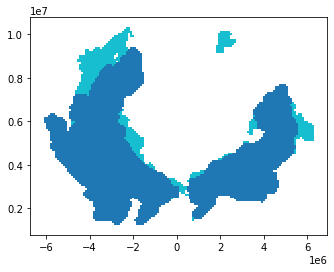

In [2]:
dem_tiles_index_path = '/projects/shared-buckets/nathanmthomas/dem30m_tiles.geojson'
dem_tiles_index = gpd.read_file(dem_tiles_index_path)
dem_tiles_index['tile_num'] = dem_tiles_index.index

boreal_tile_index_path = '/projects/my-public-bucket/boreal_tiles_v003.gpkg'
boreal_tile_index = gpd.read_file(boreal_tile_index_path)
boreal_tile_index.plot(column='tile_version')

#boreal_tile_index[boreal_tile_index.tile_version=='version 2']

In [3]:
if False:
    c = gpd.read_file('/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map.gpkg')
    c.path.to_list()[0]

In [4]:
if False:
    # One time, make a column with the s3 path
    c['s3_path'] = c['path'].str.replace('https://esa-worldcover.s3.eu-central-1.amazonaws.com', 's3://esa-worldcover') + '/' + c['file']

    c.s3_path.to_list()[0]
    c.to_file('/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg', driver='GPKG', overwrite=True)

#### Set up vars to pass to each script

In [5]:
#TILE_NUM = 12967
#INDEX_FN = '/projects/shared-buckets/lduncanson/dem30m_tiles_v2.geojson'#
#INDEX_LYR = 'dem30m_tiles_v2'

ID_COL_NAME = 'tile_num'
TILE_NUM = 1615 #1580 #, 3300, 3679, 3864 #27367 #1933 #3585 #1927 #131 #3417# 4253
INDEX_FN = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg'
INDEX_LYR = 'boreal_tiles_v003'

if False:
    HYBAS_FILE = 'hybas_lake_as_lev07_v1c'
    ID_COL_NAME = 'HYBAS_ID'
    TILE_NUM = 4070084980 #4070000010 #3417# 4253
    INDEX_FN = f'/projects/my-public-bucket/analyze_agb/hydrobasins/{HYBAS_FILE}.shp'
    ADD_STR = '-reprj'
    INDEX_REPRJ_FN = INDEX_FN.replace('.shp', ADD_STR+'.gpkg')
    
    # Reproject hydrobasin to equal area (boreal_tiles)
    gpd.read_file(INDEX_FN).to_crs(boreal_tile_index.crs).to_file(INDEX_REPRJ_FN, driver='GPKG')
    
    INDEX_LYR = HYBAS_FILE + ADD_STR
    z = gpd.read_file(INDEX_FN)
    
if False:
    z[z[ID_COL_NAME]==TILE_NUM].plot()

    z = gpd.read_file(INDEX_REPRJ_FN)
    z[z[ID_COL_NAME]==TILE_NUM].plot()

In [6]:
if False:
    c = gpd.read_file('/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg')
    c.head()

## Run build_stack.py with hydrobasins
* reprojected to equal area using boreal_tiles_index
* s0 output has same res and crs as output AGB vrt

In [7]:
RASTER_NAME = 'esa_worldcover_v100_2020'
COVAR_TILE_FN = '/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg'
IN_COVAR_S3_COL = 's3_path'
NODATA_VAL = 0

# This needs to be correctlyy in 4326 - 
RASTER_NAME = 'biomass_prelim'
COVAR_TILE_FN = '/projects/shared-buckets/lduncanson/DPS_tile_lists/AGB_tindex_master.json'
IN_COVAR_S3_COL = 's3'
NODATA_VAL = -9999

Reset projection and reproject...
/projects/my-public-bucket/analyze_agb/AGB_tindex_master.json


NameError: name 'z' is not defined

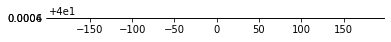

In [8]:
x = gpd.read_file(COVAR_TILE_FN)

if RASTER_NAME == 'biomass_prelim':

    print('Reset projection and reproject...')
    x = x.set_crs(boreal_tile_index.crs, allow_override=True, inplace=True).to_crs(4326)

    # Write a new JSON that should have the prj set correctly in 4326
    COVAR_TILE_FN = os.path.join('/projects/my-public-bucket/analyze_agb' , os.path.split(COVAR_TILE_FN)[1])
    print(COVAR_TILE_FN)
    x.to_file(COVAR_TILE_FN, driver='GeoJSON', overwrite=True)

# Verify 4326
ax = x.plot()
z[z[ID_COL_NAME]==TILE_NUM].to_crs(4326).plot(color='red', ax=ax)


In [247]:
# index shapes should be in equal area
# covar tiles should be in 4326
args = f"--in_tile_fn {INDEX_REPRJ_FN} \
--in_tile_id_col {ID_COL_NAME} \
--in_tile_num {TILE_NUM} \
--tile_buffer_m 0 \
--in_tile_layer {INDEX_LYR} \
-o /projects/test_data/ \
--topo_off \
--covar_src_name {RASTER_NAME} \
--covar_tile_fn {COVAR_TILE_FN} \
--in_covar_s3_col {IN_COVAR_S3_COL} \
--input_nodata_value {NODATA_VAL} \
--clip" #<-- testing a clip to polygon
print(args)
!python build_stack.py $args

--in_tile_fn /projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_as_lev07_v1c-reprj.gpkg --in_tile_id_col HYBAS_ID --in_tile_num 4070084980 --tile_buffer_m 0 --in_tile_layer hybas_lake_as_lev07_v1c-reprj -o /projects/test_data/ --topo_off --covar_src_name biomass_prelim --covar_tile_fn /projects/my-public-bucket/analyze_agb/AGB_tindex_master.json --in_covar_s3_col s3 --input_nodata_value -9999 --clip
/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
The covariate's filename(s) intersecting the 0 m bbox for tile id 4070084980:
 s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_ubuntu/master/2021/10/16/05/28/01/047798/boreal_agb_20211016_3975_cog.tif
s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_ubuntu

In [248]:
cog_fn = '/projects/tmp/esa_worldcover_v100_2020_131_cog.tif'
cog_fn = f'/projects/tmp/{RASTER_NAME}_{TILE_NUM}_cog.tif'
covar_stack_names = ['esa worldcover']

/projects/tmp/biomass_prelim_4070084980_cog.tif
4
(3813, 1930)
(3813, 1930)
-1.0075219858189395e+43


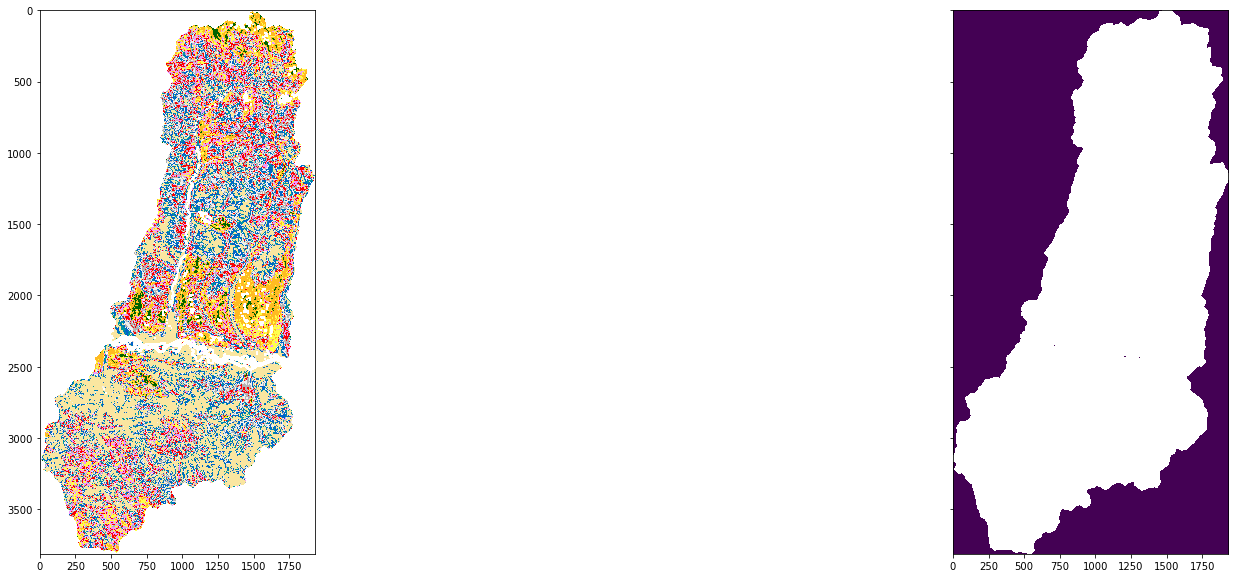

In [249]:
## %%time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import rasterio
from rasterio.plot import show_hist, show
import numpy.ma as ma

# Read back in the topo_stack_cog_fn and plot
print(cog_fn)
with rasterio.open(cog_fn) as dataset:

    print(dataset.count)
    
    covar_stack = dataset.read(1)
    print(covar_stack.shape)

    lc_mask = covar_stack.copy()
    print(lc_mask.shape)
    
    # For LC value of interest, set to 1, else mask out
    LC_VAL = 90
    #lc_mask = np.ma.masked_array(covar_stack, mask=covar_stack[covar_stack != 10], fill_value=1)
    #lc_mask = ma.masked_where(covar_stack == LC_VAL, 1)
    lc_mask[np.where(covar_stack > 0)] = 0
    lc_mask[np.where(covar_stack == LC_VAL)] = 1
    
    lc_mask = ma.masked_values(lc_mask, 0)
    print(lc_mask.sum())
    
    names_worldcover = ['nodata','Trees', 'Shrubland', 'Grassland','Cropland','Built-up','Barren / sparse vegetation','Snow and ice','Open water','Herbaceous wetland','Mangroves','Moss and lichen']
    cols_worldcover = ["white","#006400","#ffbb22","#ffff4c","#f096ff","#fa0000","#b4b4b4","#f0f0f0","#0064c8","#0096a0","#00cf75","#fae6a0"]
    #cols_worldcover = ["white","green","orange","yellow","purple","red","brown","gray","blue","pink","cyan","black"]
    cols_mask = ["white", "red"]
    # Plot data using nicer colors

    values_worldcover = [0,10,20,30,40,50,60,70,80,90,95,100]
    values_mask = [0,1]
    
    cmap_worldcover = ListedColormap(cols_worldcover)
    norm_worldcover = BoundaryNorm(values_worldcover, len(cols_worldcover))
    
    cmap_masked = ListedColormap(cols_mask)
    norm_masked= BoundaryNorm(values_mask, len(cols_mask))

    # To plot with a legend:
    # https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/classify-plot-raster-data-in-python/
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30,10), sharex=True, sharey=True)
    ax1.imshow(covar_stack, cmap=cmap_worldcover, norm=norm_worldcover)
    ax2.imshow(lc_mask, clim=(0,1))
    #show(lc_mask, cmap=cmap_masked, norm=norm_masked)
    #show_hist(lc_mask, bins=len(values_masked)+1, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram of ESA Worldcover Class Values")

In [ ]:
# This should work once you figure out the move axis of the stack: need 3 bands
n: int = len(covar_stack)
covar_stack_cmaps = ["Spectral"]
print(covar_stack.shape)

fig, axes = plt.subplots(1,n, figsize=(n*3,5))

for i in range(n):
    
    print(covar_stack[i].min(), covar_stack[i].max())
    array_to_show = covar_stack[i]
    clims = (np.nanpercentile(covar_stack[i], 10), np.nanpercentile(covar_stack[i], 90))
    
    if 'elevation' in covar_stack_names[i]:
        #Replace elevation with its hillshade for display purposes
        array_to_show = hillshade(covar_stack[i],315,45)
        clims = None
    
    show(array_to_show, ax=axes[i], cmap=covar_stack_cmaps[i], clim=clims, title=covar_stack_names[i])
    
    fig, (axmap, axhist) = plt.subplots(1,2, figsize=(10,5))
    show(array_to_show, ax=axmap, cmap=covar_cmaps[i], clim=clims, title=covar_stack_names[i])
    show_hist(covar_stack[i], ax=axhist, title=covar_stack_names[i], bins=50, lw=0.0, stacked=True, alpha=1)


if False:
    fig, axes = plt.subplots(1,n, figsize=(n*3,30))

    for i in range(n):
        show_hist(covar_stack[i], ax=axes[i], title=covar_stack_names[i], bins=50, lw=0.0, stacked=True, alpha=1)

# Tile size tests

Here are the bad tiles Nathan identified in `Find_small_tiles.ipynb`

In [104]:
df = pd.read_csv('/projects/my-public-bucket/DPS_tile_lists/HLS_irregular_tiles.csv')
#boreal_tile_index = gpd.read_file('/projects/my-public-bucket/boreal_tiles_v003.gpkg')#.to_crs(4326)

#geom_list = []
tile_num_list = []

for i in df["IrregularTiles"]:
    tile_num = int(i.split('_')[9])
    #geom_list.append((boreal_tile_index['geometry'][boreal_tile_index['tile_num']==tile_num]).geometry.values[0])
    tile_num_list.append(tile_num)
    
print(tile_num_list)

[1941, 2149, 2457, 1448, 1867, 1797, 2010, 1105, 2155, 2779, 1159, 991, 2082, 1731, 2148, 3770, 2301, 36692, 1937, 37142, 37143, 4108, 1334, 36917, 3307, 3951, 3393, 1392, 3486, 2009, 2075, 1798, 2378, 3771, 1273, 1393, 34674, 1050, 1214, 1615, 1938, 2942, 3865, 2223, 2859]


In [88]:

# Already tested these tiles:
# 1615
TILE_NUM = tile_num_list[0] 


# Testing shape forcing on bad and good tiles
Does forcing shape do anything to bad tiles , good tiles
bad tiles: eg 1615  
good tiles: eg 1614  

Results (explore_tiles.qgis)  
`--shape` is the best way to get aligned results for bad and good tiles for HLS, LC, and Topo

For now, always run Topos with `3.1.5_dps.py` instead of trying to do a topo run with `build_stack.py`

however, still a few issues - and they seem to be with `build_stack.py`:  
1. not clear how to get LC (`build_stack.py`) to return the same grid as HLS (`3.1.2_dps.py`) and Topo stack (`3.1.5_dps.py`)
2. results from (`build_stack.py`) shows a nodata (0 value) on half of right side and half of bottom side of good & bad tiles  
3. topo (from `build_stack.py`) show similar nodata pattern, but sometimes its 2 pixels on half of right side. 

In [8]:
OUTDIR = '/projects/test_data'
OUTDIR_SHAPE_ON = OUTDIR + '/shape_on'
OUTDIR_SHAPE_OFF = OUTDIR + '/shape_off'
# Manually set align=True for write_cog() in build_stack
OUTDIR_SHAPE_ON_align = OUTDIR + '/shape_on_align'
OUTDIR_SHAPE_OFF_align = OUTDIR + '/shape_off_align'
!mkdir -p $OUTDIR_SHAPE_ON
!mkdir -p $OUTDIR_SHAPE_OFF
!mkdir -p $OUTDIR_SHAPE_ON_align
!mkdir -p $OUTDIR_SHAPE_OFF_align

#### original topo tiles from 3.1.5_dps.py all seem good (3000x3000)

In [9]:
import rasterio as rio
t = pd.read_csv('/projects/my-public-bucket/DPS_tile_lists/Topo_tindex_master.csv')
f = t[t.tile_num == TILE_NUM].s3_path.to_list()[0]
ds = rio.open(f)
print(f"Tile #: {TILE_NUM}\n{f}\n{ds.profile['height']} x {ds.profile['width']}")
print(f"CRS of Topo:\n{ds.crs}")
print(f"CRS of tiles index:\n{boreal_tile_index.crs}")

Tile #: 1615
s3://maap-ops-workspace/nathanmthomas/dps_output/do_topo_stack_3-1-5_ubuntu/ops/2021/09/16/03/56/41/782830/Copernicus_1615_covars_cog_topo_stack.tif
3000 x 3000
CRS of Topo:
PROJCS["unknown",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
CRS of tiles index:
PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["

In [91]:
import s3fs
s3 = s3fs.S3FileSystem(anon=True)
s3.download(f, '/projects/test_data/dload/'+os.path.basename(f))

#### build_stack.py with ESA LC

RESULT:  

When build_stack.py is run with `--shape 3000` ..  
..the fit to the tile geom is good, but there is a NoData line of pixels
  
bad tiles and good tiles?  
fits perfectly in tile geom? yes    
no half pixel shift? no

Does HLS `--shape 3000` show same result?  

In [11]:
# ESA Worldcover 2020
BUILD_STACK_DICT = {
            #'INDEX_FN': '/projects/my-public-bucket/boreal_tiles_v003.gpkg',
            'INDEX_FN': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v003.gpkg',
            'ID_COL_NAME': 'tile_num',
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR': 'boreal_tiles_v003',
            # Worldcover data is accessed via its footprint, with a 's3_path' col identifying the s3 locations of each tile
            'RASTER_NAME': 'esa_worldcover_v100_2020',
            #'COVAR_TILE_FN': '/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg',
            'COVAR_TILE_FN': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'OUTDIR': '',
            'NODATA_VAL': 0,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        }

In [15]:
# INDEX clip shapes should be in equal area
# COVAR_TILE_FN tiles (of raster COGs) should be in 4326

args = f"\
    --in_tile_fn {BUILD_STACK_DICT['INDEX_FN']} \
    --in_tile_id_col {BUILD_STACK_DICT['ID_COL_NAME']} \
    --tile_buffer_m 0 \
    --in_tile_layer {BUILD_STACK_DICT['INDEX_LYR']} \
    --topo_off \
    --covar_src_name {BUILD_STACK_DICT['RASTER_NAME']} \
    --covar_tile_fn {BUILD_STACK_DICT['COVAR_TILE_FN']} \
    --in_covar_s3_col {BUILD_STACK_DICT['IN_COVAR_S3_COL']} \
    --input_nodata_value {BUILD_STACK_DICT['NODATA_VAL']} \
    --clip"

args_LIST = []

if False:
    # Bad tile; Forcing shape (SHAPE ON)
    args_LIST.append(args + f" --in_tile_num {TILE_NUM} --shape 3000 -o {OUTDIR_SHAPE_ON}")
    # Good tile; Forcing shape (SHAPE ON)
    args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} --shape 3000 -o {OUTDIR_SHAPE_ON}")
    # Bad tile; Not forcing shape (SHAPE OFF)
    args_LIST.append(args + f" --in_tile_num {TILE_NUM} -o {OUTDIR_SHAPE_OFF}")
    # Good tile; Not forcing shape (SHAPE OFF)
    args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} -o {OUTDIR_SHAPE_OFF}")

# align=True test
# To run these, manually set align=True for write_cog() in build_stack
# Bad tile; Forcing shape (SHAPE ON)
if True:
    # Bad tile; Forcing shape (SHAPE ON)
    args_LIST.append(args + f" --in_tile_num {TILE_NUM} --shape 3000 -o {OUTDIR_SHAPE_ON_align}")
    # Good tile; Forcing shape (SHAPE ON)
    args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} --shape 3000 -o {OUTDIR_SHAPE_ON_align}")
    # Bad tile; Not forcing shape (SHAPE OFF)
    args_LIST.append(args + f" --in_tile_num {TILE_NUM} -o {OUTDIR_SHAPE_OFF_align}")
    # Good tile; Not forcing shape (SHAPE OFF)
    args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} -o {OUTDIR_SHAPE_OFF_align}")

for args in args_LIST:
    !python /projects/Developer/icesat2_boreal/lib/build_stack.py $args

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

---Running build_stack()---

The covariate's filename(s) intersecting the 0 m buffered bbox for tile id 1615:
 s3://esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N45W084_Map.tif
in_bbox: [5048522.564673773, 5193303.643996402, 5138522.529666357, 5283303.645755118]
Getting output height and width from input shape arg...
3000 x 3000
Writing stack as cloud-optimized geotiff: /projects/test_data/shape_on_align/esa_worldcover_v100_2020_1615_cog.tif
Clipping to feature polygon...
Orig stack shape:		 (1, 3000, 3000)
Output resolution:		 (30, 30)
Writing img to memory...
/projects/Developer/icesat2_boreal/lib/build_stack.py:104: RasterioDeprecationWarning: Source dataset should be ope

#### build_stack.py for a topo stack

##### TODO: check build_stack for topo stack creation (topo_off = False)
is build_stack actually clipping to clip_geom (line 81) so that a buffered DEM is clipped down to 3000x3000 after making the topo stack covars? Seems like its not. Check this

In [100]:
args = f"\
    --in_tile_fn {INDEX_FN} \
    --in_tile_id_col tile_num \
    --in_tile_num {TILE_NUM} \
    --tile_buffer_m 120 \
    --in_tile_layer {INDEX_LYR} \
    --covar_src_name Copernicus_buildstack \
    --covar_tile_fn /projects/shared-buckets/nathanmthomas/dem30m_tiles.geojson \
    --in_covar_s3_col s3 \
    --clip"
args_LIST = []
# Bad tile; Forcing shape (SHAPE ON)
args_LIST.append(args + f" --in_tile_num {TILE_NUM} --shape 3000 -o {OUTDIR_SHAPE_ON}")
# Good tile; Forcing shape (SHAPE ON)
args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} --shape 3000 -o {OUTDIR_SHAPE_ON}")
# Bad tile; Not forcing shape (SHAPE OFF)
args_LIST.append(args + f" --in_tile_num {TILE_NUM} -o {OUTDIR_SHAPE_OFF}")
# Good tile; Not forcing shape (SHAPE OFF)
args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} -o {OUTDIR_SHAPE_OFF}")

for args in args_LIST:
    !python /projects/Developer/icesat2_boreal/lib/build_stack.py $args

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

---Running build_stack()---

The covariate's filename(s) intersecting the 120 m buffered bbox for tile id 1941:
 s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N42_00_W088_00_DEM/Copernicus_DSM_COG_10_N42_00_W088_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N42_00_W089_00_DEM/Copernicus_DSM_COG_10_N42_00_W089_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N43_00_W088_00_DEM/Copernicus_DSM_COG_10_N43_00_W088_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N43_00_W089_00_DEM/Copernicus_DSM_COG_10_N43_00_W089_00_DEM.tif
in_bbox: [5408402.053990538, 4743183.9877320975, 5498642.025561074, 4833424.068427608]
Getting output height and width from buffered (buffer=12

#### Test a run of the topo stacks: 3.1.5_dps.py

In [101]:
args = f"--in_tile_fn {INDEX_FN} \
--in_tile_num {TILE_NUM} \
--tile_buffer_m 120 \
--in_tile_layer {INDEX_LYR} \
--topo_tile_fn /projects/shared-buckets/nathanmthomas/dem30m_tiles.geojson"

args_LIST = []
# Bad tile; Forcing shape (SHAPE ON)
args_LIST.append(args + f" --in_tile_num {TILE_NUM} --shape 3000 -o {OUTDIR_SHAPE_ON}")
# Good tile; Forcing shape (SHAPE ON)
args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} --shape 3000 -o {OUTDIR_SHAPE_ON}")
# Bad tile; Not forcing shape (SHAPE OFF)
args_LIST.append(args + f" --in_tile_num {TILE_NUM} -o {OUTDIR_SHAPE_OFF}")
# Good tile; Not forcing shape (SHAPE OFF)
args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} -o {OUTDIR_SHAPE_OFF}")

for args in args_LIST:
    !python 3.1.5_dps.py $args

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
The DEM filename(s) intersecting the 120 m buffered bbox for tile id 1941:
 s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N42_00_W088_00_DEM/Copernicus_DSM_COG_10_N42_00_W088_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N42_00_W089_00_DEM/Copernicus_DSM_COG_10_N42_00_W089_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N43_00_W088_00_DEM/Copernicus_DSM_COG_10_N43_00_W088_00_DEM.tif
s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N43_00_W089_00_DEM/Copernicus_DSM_COG_10_N43_00_W089_00_DEM.tif
in_bbox: [5408402.053990538, 4743183.9877320975, 5498642.025561074, 4833424.068427608]
Getting output height and width from input shape arg...
3000 x 3000
Input nodata isnt provided

In [58]:
ds = rio.open('/projects/test_data/Copernicus_1615_cog_topo_stack.tif')
print(f"{ds.profile['height']} x {ds.profile['width']}")

3001 x 3000


### Examine `HLS` composite types: combined S30 and L30

In [146]:
# These tiles had artifacts in the 2019-2021 HLS comp with L30

# 2021 is first year S30 is available it seems

# Can we improve on c2020 comps (2019-2021) with a 2021 comp using S30 & L30 for Jule-August

TILES_with_artefacts_LIST = [237,984,702,1858,3387]

In [147]:
MS_DATA_TYPE = 'HLS'#'LS8' # 'HLS'

if MS_DATA_TYPE == 'LS8':
    SAT_API = 'https://landsatlook.usgs.gov/sat-api'
else:
    SAT_API = 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD'
    
MAX_CLOUDS = 50
SEASON_START = '07-01'
SEASON_STOP = '08-15'
YEAR_START = '2021'
YEAR_STOP = '2021'
RUN_NAME = f'mc{MAX_CLOUDS}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}'
RUN_NAME

'mc50_07-01_08-15_2021_2021'

##### 3.1.2_dps.py

In [148]:
for TILE_NUM in TILES_with_artefacts_LIST:

    # Loop over the HLS product here
    for HLS_PRODUCT in ['S30','L30','H30']:

        OUTDIR = f'/projects/test_data/HLS_testing/{HLS_PRODUCT}'
        !mkdir -p $OUTDIR

        args = f"-i {INDEX_FN} \
        --composite_type {MS_DATA_TYPE} \
        -lyr {INDEX_LYR} \
        -a {SAT_API} \
        --tile_buffer_m 0 \
        --in_tile_num {TILE_NUM} \
        -o {OUTDIR} \
        -sy {YEAR_START} -ey {YEAR_STOP} -smd {SEASON_START} -emd {SEASON_STOP} -mc {MAX_CLOUDS} -t {MS_DATA_TYPE} \
        --shape 3000 \
        --hls_product {HLS_PRODUCT}"

        #!python 3.1.2_dps.py $args
        cmd = f'python 3.1.2_dps.py {args}'
        !echo $cmd
        !echo
        !eval $cmd

python 3.1.2_dps.py -i /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg --composite_type HLS -lyr boreal_tiles_v003 -a https://cmr.earthdata.nasa.gov/stac/LPCLOUD --tile_buffer_m 0 --in_tile_num 237 -o /projects/test_data/HLS_testing/S30 -sy 2021 -ey 2021 -smd 07-01 -emd 08-15 -mc 50 -t HLS --shape 3000 --hls_product S30

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Tiles path:		 /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg
Tile number:		 237
Output res (m):		 30
in_bbox:		 [-2871478.0000000047, 7893304.000000009, -2781478.0000000047, 7983304.000000009]
bbox 4326:		 [31.484204400240426, 61.34666526224287, 33.90972227535535, 62.45647776409287]
Getting output dims from input shape arg...
Output dims:		30

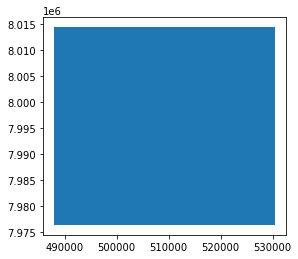

In [30]:
INDEX_FN = '/projects/test_data/SajamaAOI.gpkg'
#PROJECTED_FN = '/projects/test_data/SajamaAOI_albers.gpkg'
#gpd.read_file(INDEX_FN).to_crs(gpd.read_file('/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg').crs).to_file(PROJECTED_FN, driver='GPKG')

PROJECTED_FN = '/projects/test_data/SajamaAOI_utm.gpkg'
gpd.read_file(INDEX_FN).to_crs(32719).to_file(PROJECTED_FN, driver='GPKG')
c = gpd.read_file(PROJECTED_FN)
c.plot()

In [24]:
import fiona
from CovariateUtils import *

In [31]:
INDEX_FN = PROJECTED_FN

INDEX_LYR = fiona.listlayers(INDEX_FN)[0]
OUTDIR_SAJAMA = '/projects/test_data/test_sajama'

args = f"-i {INDEX_FN} \
-lyr {INDEX_LYR} \
-a {SAT_API} \
--tile_buffer_m 0 \
--in_tile_num 1 \
-o {OUTDIR_SAJAMA} \
-sy {YEAR_START} -ey {YEAR_STOP} -smd {SEASON_START} -emd {SEASON_STOP} -mc {MAX_CLOUDS} -t {MS_DATA_TYPE}"

!python 3.1.2_dps.py $args

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Tiles path:		 /projects/test_data/SajamaAOI_utm.gpkg
Tile number:		 1
Output res (m):		 30
in_bbox:		 [487913.4904594717, 7976366.239692333, 530423.454751463, 8014410.17662341]
bbox 4326:		 [-69.11436803499998, -18.30228742199995, -68.71212059899995, -17.958248279999964]
Getting output height and width from buffered (buffer=0.0) original tile geometry...
1268 x 1416
get HLS data
run function
opening client
start_month_day:		 07-15
start date, end date:		 2015-07-15T00:00:00Z 2015-09-01T23:59:59Z

Conducting HLS search now...
Search query parameters:

initial results:		 12
filtered results:		 6

Search complete.

6
# of files per band:		 6
Example path to a band:		 s3://lp-prod-protected/

In [103]:
args_LIST = []

args = f"-i {INDEX_FN} \
-lyr {INDEX_LYR} \
-a {SAT_API} \
--tile_buffer_m 0 \
-sy {YEAR_START} -ey {YEAR_STOP} -smd {SEASON_START} -emd {SEASON_STOP} -mc {MAX_CLOUDS} -t {MS_DATA_TYPE}"

# Bad tile; Forcing shape (SHAPE ON)
args_LIST.append(args + f" --in_tile_num {TILE_NUM} --shape 3000 -o {OUTDIR_SHAPE_ON}")
# Good tile; Forcing shape (SHAPE ON)
args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} --shape 3000 -o {OUTDIR_SHAPE_ON}")
# Bad tile; Not forcing shape (SHAPE OFF)
args_LIST.append(args + f" --in_tile_num {TILE_NUM} -o {OUTDIR_SHAPE_OFF}")
# Good tile; Not forcing shape (SHAPE OFF)
args_LIST.append(args + f" --in_tile_num {TILE_NUM-1} -o {OUTDIR_SHAPE_OFF}")

for args in args_LIST:
    #print(args)
    !python 3.1.2_dps.py $args

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Tiles path:		 /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg
Tile number:		 1941
Output res (m):		 30
in_bbox:		 [5408522.053990538, 4743303.9877320975, 5498522.025561074, 4833304.068427608]
bbox 4326:		 [-88.77776561375481, 42.685095496309216, -87.49516749159045, 43.66060430674119]
Getting output height and width from input shape arg...
3000 x 3000
get HLS data
run function
opening client
start_month_day:		 07-15
start date, end date:		 2015-07-15T00:00:00Z 2015-09-01T23:59:59Z

Conducting HLS search now...
Search query parameters:

initial results:		 24
filtered results:		 16

Search complete.

16
# of files per band:		 16
Example path to a band:		 s3://lp-prod-protected

# tile_atl08

#### Test a run of tile_atl08.py

In [115]:
!python /projects/register-algorithm /projects/Developer/icesat2_boreal/dps/alg_2-4/algorithm_config.yaml

{
  "algorithm_name": "run_tile_atl08",
  "code_version": "tile_atl08",
  "environment_name": "ubuntu",
  "repo_url": "https://repo.ops.maap-project.org/icesat2_boreal/icesat2_boreal.git",
  "docker_container_url": "mas.maap-project.org:5000/root/ade-base-images/r:latest",
  "queue": "maap-dps-worker-8gb",
  "algorithm_description": null,
  "build_command": "icesat2_boreal/dps/build_command_main.sh",
  "script_command": "icesat2_boreal/dps/alg_2-4/run_tile_atl08.sh",
  "disk_space": "10GB",
  "algorithm_params": [
    {
      "field": "in_tile_num",
      "download": false
    },
    {
      "field": "in_tile_fn",
      "download": true
    },
    {
      "field": "in_tile_layer",
      "download": false
    },
    {
      "field": "csv_list_fn",
      "download": false
    },
    {
      "field": "topo_stack_list_fn",
      "download": false
    },
    {
      "field": "landsat_stack_list_fn",
      "download": false
    },
    {
      "field": "landsat_cols_list",
      "download": f

## Run tile_atl08 over a list of tiles  
for what will be tiles with dummy output ATL08 data frames (1 obs)

In [122]:
OUTDIR = '/projects/my-public-bucket/tile_atl08'
!mkdir -p $OUTDIR

INCOMPLETE_IRREG_IILES = [2375, 3301, 3302, 3117, 4034]

TILE_NUM_LIST = [3653, 4151, 3827, 40664, 2745,
                 1321, 1326, 1318, 611, 577, 976, 1316, 36019, 36238, 36237,
                 36685, 39464, 4418, 4308, 4024, 4107, 4104, 4029, 2505, 
                 3417, 41809, 42558, 24113, 24394, 24674, 26341, 26340, 
                 25184, 40239, 39832, 36401, 35285, 35059,
                 35060, 34834, 34606, 3402, 3215, 3035, 2782, 1278, 1108, 26554, 
                 10, 21, 155, 250, 357, 448, 484, 608, 609, 650, 738, 34607, 35955, 37080, 39630, 4150, 4141, 4366, 3978]
len(TILE_NUM_LIST)
NEED_LIST = []
HAVE_LIST = []
for TILE_NUM in TILE_NUM_LIST:
    f1 = os.path.exists(os.path.join(OUTDIR, f'atl08_005_30m_filt_topo_landsat_20230211_{TILE_NUM:{0}{4}}.csv'))
    f2 = os.path.exists(os.path.join(OUTDIR, f'atl08_005_30m_filt_topo_landsat_20230212_{TILE_NUM:{0}{4}}.csv'))
    f3 = os.path.exists(os.path.join(OUTDIR, f'atl08_005_30m_filt_topo_landsat_20230213_{TILE_NUM:{0}{4}}.csv'))
                        
    if not f1 and not f2:
        NEED_LIST.append(TILE_NUM)
    else:
        HAVE_LIST.append(TILE_NUM)
print(NEED_LIST)
print(HAVE_LIST)

[]
[3653, 4151, 3827, 40664, 2745, 1321, 1326, 1318, 611, 577, 976, 1316, 36019, 36238, 36237, 36685, 39464, 4418, 4308, 4024, 4107, 4104, 4029, 2505, 3417, 41809, 42558, 24113, 24394, 24674, 26341, 26340, 25184, 40239, 39832, 36401, 35285, 35059, 35060, 34834, 34606, 3402, 3215, 3035, 2782, 1278, 1108, 26554, 10, 21, 155, 250, 357, 448, 484, 608, 609, 650, 738, 34607, 35955, 37080, 39630, 4150, 4141, 4366, 3978]


In [121]:
%%time

TILE_NUM_LIST = NEED_LIST

for TILE_NUM in TILE_NUM_LIST:
    args = f"\
    -LC_filter True \
    --extract_covars \
    --do_30m \
    --do_dps \
    -years_list 2019 2020 2021 \
    -o {OUTDIR} \
    -in_tile_num {TILE_NUM} \
    -in_tile_fn {INDEX_FN} \
    -in_tile_layer {INDEX_LYR} \
    -in_tile_id_col tile_num \
    -csv_list_fn /projects/shared-buckets/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_tindex_master.csv \
    -topo_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv \
    -landsat_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master.csv \
    -landsat_cols_list Blue Green Red NIR SWIR SWIR2 NDVI SAVI MSAVI NDMI EVI NBR NBR2 TCB TCG TCW ValidMask Xgeo Ygeo JulianDate yearDate \
    -user_stacks nathanmthomas \
    -user_atl08 lduncanson \
    -thresh_sol_el 5 \
    -v_ATL08 5 -minmonth 4 -maxmonth 10"
    print(args)
    !python tile_atl08.py $args

    -LC_filter True     --extract_covars     --do_30m     --do_dps     -years_list 2019 2020 2021     -o /projects/my-public-bucket/tile_atl08     -in_tile_num 39630     -in_tile_fn /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg     -in_tile_layer boreal_tiles_v003     -in_tile_id_col tile_num     -csv_list_fn /projects/shared-buckets/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_tindex_master.csv     -topo_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv     -landsat_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master.csv     -landsat_cols_list Blue Green Red NIR SWIR SWIR2 NDVI SAVI MSAVI NDMI EVI NBR NBR2 TCB TCG TCW ValidMask Xgeo Ygeo JulianDate yearDate     -user_stacks nathanmthomas     -user_atl08 lduncanson     -thresh_sol_el 5     -v_ATL08 5 -minmonth 4 -maxmonth 10
/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning

In [54]:


rds_fn = tindex.tail().local_path.to_list()[0].replace('.tif', '_stats.Rds').replace('/projects/my-private-bucket','s3://maap-ops-workspace/lduncanson')
print(rds_fn)
rds_fn
local_rds_fn = '/projects/test_data/' + os.path.basename(rds_fn)
local_rds_fn

s3 = s3fs.S3FileSystem(anon=True)
s3.download(rds_fn, local_rds_fn)

result = pyreadr.read_r(local_rds_fn) # also works for RData

# done! 
# result is a dictionary where keys are the name of objects and the values python
# objects. In the case of Rds there is only one object with None as key
#df = result[None] # extract the pandas data frame 

s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_v3/2022/11/11/22/38/21/238233/boreal_agb_202211111668206230_25745_stats.Rds


In [55]:
result

OrderedDict()

In [1]:
import pandas as pd

In [3]:
IRREGULAR_TILES_FN = '/projects/my-public-bucket/DPS_tile_lists/HLS_irregular_tiles.csv'
original_IRREGULAR_TILES_LIST = []
df = pd.read_csv(IRREGULAR_TILES_FN)

for i in df["IrregularTiles"]:
    tile_num = int(i.split('_')[9])
    original_IRREGULAR_TILES_LIST.append(tile_num)



In [8]:
TILES_IRREGULAR_LIST = [3400,
 3395,
 2698,
 3301,
 992,
 993,
 1216,
 1800,
 1934,
 1933,
 3030,
 1617,
 3302,
 2380,
 2619,
 3952,
 3493,
 1866,
 4035,
 1672,
 34900,
 1274,
 34899,
 36020,
 36468,
 3399,
 4227,
 34210,
 2618,
 1450,
 2944,
 3120,
 3954,
 2011,
 1449,
 1865,
 2153,
 2151,
 2154,
 1275,
 3029,
 4112,
 1733,
 2375,
 895,
 3585,
 2381,
 2152,
 3117,
 2224,
 2229,
 1799,
 4034,
 2379,
 34211,
 3861]

In [9]:
# Check if any matches between 2 lists: if nothing, then the lists are unique
set(original_IRREGULAR_TILES_LIST) & set(TILES_IRREGULAR_LIST)

set()